### Assignment 7: Ksenia Luu, Sunny Yurasek, Daniel Bukowski

#### Overview

This assignment follows the same structure as Assignment 6. We will employ at least a 2x2 completely crossed experimental design. We will again use a simple training-and-test regimen, perhaps with a three-way partitioning of the data into training, dev, and test sets. The factors in the design may include numbers of layers and/or nodes within layers, types of layers (convolutional or pooling), and/or other hyperparameters. We will utilize convolutional neural networks (CNNs) within Python TensorFlow. 
<br>
<br>
The original data consisted of 25,000 images of cats and dogs. To ensure that the problem may be run on typical personal computers with limited memory and no graphical processing units (GPUs), we work with only 2,000 images: 1,000 cat images and 1,000 dog images. The original image files are provided in a zip archive.
<br>
<br>
After the data have been prepared for analysis in a jump-start program (included in the zip archive cats-dogs-jump-start-v002.zip under Modules / Technology Resources), we will divide the images into training, dev, and test sets for evaluating alternative neural network models per our experimental design.

#### Management Question

Assume that we are providing advice to a website provider who is looking for tools to automatically label images provided by end users. As we look across the factors in the study, making recommendations to management about image classification, we are most concerned about achieving the highest possible accuracy in image classification. That is, we should be willing to sacrifice training time for model accuracy. What type of machine learning model works best? If it is a convolutional neural network, what type of network should we use? Part of this recommendation may concern information about the initial images themselves (input data for the classification task). What types of images work best?

In [91]:
%matplotlib inline
import numpy as np
import os
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from collections import OrderedDict
from matplotlib.backends.backend_pdf import PdfPages  # plot to pdf files
import time #to time how long models take to run 
from __future__ import division, print_function, unicode_literals
import tensorflow as tf
import keras

In [92]:
#jupyter display options
pd.set_option('display.notebook_repr_html', True) 
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

# Plot Options
#print(plt.style.available)
#plt.style.use('classic')
plt.rc('font', size=12)
plt.rc('figure', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('axes', titlesize=12)

In [93]:
RANDOM_SEED = 9999

# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


#### Load CATS_DOGS Data

In [94]:
#CatsDogs
height = 64
width = 64   

path=r'''C:\Users\sedwards\OneDrive - Constellation Brands\Documents\Northwestern\PREDICT422\Assignment 7\cats-dogs-jump-start-v002'''
os.chdir(path)
    
#CatsDogs# 

# Under the working directory, data files are in directory cats_dogs_64_128 
# Read in cats and dogs grayscale 64x64 files to create training data
cats_1000_64_64_1 = np.load('cats_dogs_64-128/cats_1000_64_64_1.npy')
dogs_1000_64_64_1 = np.load('cats_dogs_64-128/dogs_1000_64_64_1.npy')
cats_1000_64_64_3 = np.load('cats_dogs_64-128/cats_1000_64_64_3.npy')
dogs_1000_64_64_3 = np.load('cats_dogs_64-128/dogs_1000_64_64_3.npy')

In [95]:
print(cats_1000_64_64_1.shape)
print(dogs_1000_64_64_1.shape)
print(cats_1000_64_64_3.shape)
print(dogs_1000_64_64_3.shape)

(1000, 64, 64, 1)
(1000, 64, 64, 1)
(1000, 64, 64, 3)
(1000, 64, 64, 3)


#### Preview our dataset

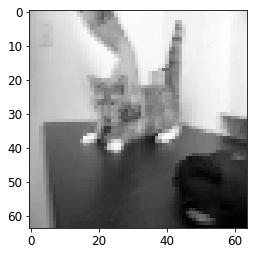

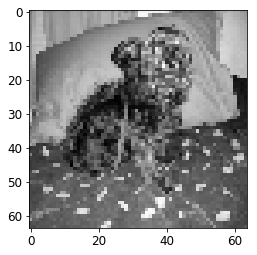

In [96]:
from matplotlib import pyplot as plt  # for display of images
def show_grayscale_image(image):
    plt.imshow(image, cmap='gray')
    #plt.axis('off')
    plt.show()
# Examine first cat and first dog grayscale images
show_grayscale_image(cats_1000_64_64_1[0,:,:,0])
show_grayscale_image(dogs_1000_64_64_1[0,:,:,0])


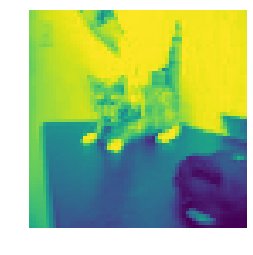

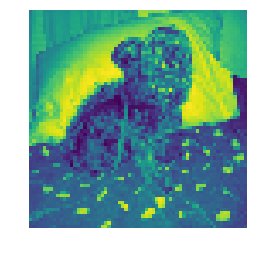

In [97]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
# for display of images
def show_color_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

show_color_image(cats_1000_64_64_3[0,:,:,0])
show_color_image(dogs_1000_64_64_3[0,:,:,0])

### Data Preparation

#### Black & White Images

In [98]:
# Grey Images
# Work the data for cats and dogs numpy arrays 
# Stack the numpy arrays for the inputs
X_cat_dog = np.concatenate((cats_1000_64_64_1, dogs_1000_64_64_1), axis = 0) 
X_cat_dog = X_cat_dog.reshape(-1,width*height) # note coversion to 4096 inputs

# Scikit Learn for min-max scaling of the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(np.array([0., 255.]).reshape(-1,1))
X_cat_dog_min_max = scaler.transform(X_cat_dog)

# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

In [99]:
# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(X_cat_dog_min_max, y_cat_dog, test_size=0.20, 
                     random_state = RANDOM_SEED)

# Random splitting of the data in to test (10%) , validation (10%)
X_valid, X_test, y_valid, y_test = \
    train_test_split(X_test, y_test, test_size=0.50, 
                     random_state = RANDOM_SEED)

In [100]:
print('Train Feature Shape: ', X_train.shape)
print('Train Label Shape: ', y_train.shape)
print('Test Feature Shape: ', X_test.shape)
print('Test Label Shape: ', y_test.shape)
print('Validation Feature Shape: ', X_valid.shape)
print('Validation Label Shape: ', y_valid.shape)

Train Feature Shape:  (1600, 4096)
Train Label Shape:  (1600,)
Test Feature Shape:  (200, 4096)
Test Label Shape:  (200,)
Validation Feature Shape:  (200, 4096)
Validation Label Shape:  (200,)


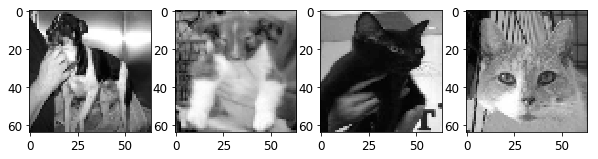

In [101]:
#training set as visual:
_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(10, 10))
ax1.imshow(X_train[0].reshape(64, 64),cmap='gray');
ax2.imshow(X_train[20].reshape(64, 64),cmap='gray');
ax3.imshow(X_train[300].reshape(64, 64),cmap='gray');
ax4.imshow(X_train[400].reshape(64, 64),cmap='gray');

#### Color Images

In [102]:
# Color Images
# Work the data for cats and dogs numpy arrays 
# Stack the numpy arrays for the inputs
X_cat_dog_3 = np.concatenate((cats_1000_64_64_3, dogs_1000_64_64_3), axis = 0) 
#X_cat_dog_3 = X_cat_dog_3.reshape(-1,width*height) # note coversion to 4096 inputs
X_cat_dog_3 = np.reshape(X_cat_dog_3, (X_cat_dog_3.shape[0], -1))

# Scikit Learn for min-max scaling of the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(np.array([0., 255.]).reshape(-1,1))
X_cat_dog_min_max_3 = scaler.transform(X_cat_dog_3)

# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog_3 = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

In [103]:
# Color Images
# Random splitting of the data in to training (80%) and test (20%)  
X_train_3, X_test_3, y_train_3, y_test_3 = \
    train_test_split(X_cat_dog_min_max_3, y_cat_dog_3, test_size=0.20, 
                     random_state = RANDOM_SEED)

# Random splitting of the data in to test (10%) , validation (10%)
X_valid_3, X_test_3, y_valid_3, y_test_3 = \
    train_test_split(X_test_3, y_test_3, test_size=0.50, 
                     random_state = RANDOM_SEED)

In [104]:
print('Train Feature Shape: ', X_train_3.shape)
print('Train Label Shape: ', y_train_3.shape)
print('Test Feature Shape: ', X_test_3.shape)
print('Test Label Shape: ', y_test_3.shape)
print('Validation Feature Shape: ', X_valid_3.shape)
print('Validation Label Shape: ', y_valid_3.shape)

Train Feature Shape:  (1600, 12288)
Train Label Shape:  (1600,)
Test Feature Shape:  (200, 12288)
Test Label Shape:  (200,)
Validation Feature Shape:  (200, 12288)
Validation Label Shape:  (200,)


In [105]:
# Checking Train, Valid, Test set distributions - aiming for roughly 50%
print('Train Set Distribution: ',np.count_nonzero(y_train_3)/1600)
print('Validation Set Distribution: ',np.count_nonzero(y_valid_3)/200)
print('Test Set Distribution: ',np.count_nonzero(y_test_3)/200)

Train Set Distribution:  0.505
Validation Set Distribution:  0.47
Test Set Distribution:  0.49


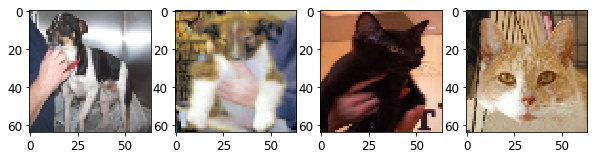

In [106]:
#training set as visual:
_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(10, 10))
ax1.imshow(X_train_3[0].reshape(64, 64,3));
ax2.imshow(X_train_3[20].reshape(64, 64,3));
ax3.imshow(X_train_3[300].reshape(64, 64,3));
ax4.imshow(X_train_3[400].reshape(64, 64,3));

### Convolutional Neural Networks - Model 1 
#### Black and White Images (64,64,1)

#### https://github.com/ageron/handson-ml/blob/master/13_convolutional_neural_networks.ipynb

In [107]:
height = 64
width = 64
channels = 1  # When working with color images use channels = 3
n_inputs = height * width
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 128
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

In [108]:
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 16 * 16])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [109]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [110]:
init = tf.global_variables_initializer()    

#start a timer 
start_time_cnn1 = time.time()

n_epochs = 20
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print("Epoch:",epoch+1, "Train Accuracy:", acc_batch, "Validation Accuracy:", acc_valid)

        save_path = saver.save(sess, "./my_catdog_model_1")
        
#end timer
total_time_cnn1 = time.time() - start_time_cnn1

print("The Convolutional Neural Network TF 1 B&W Images took %.4f seconds to train." % (total_time_cnn1))
data_nn1

Epoch: 1 Train Accuracy: 0.56 Validation Accuracy: 0.54
Epoch: 2 Train Accuracy: 0.48 Validation Accuracy: 0.475
Epoch: 3 Train Accuracy: 0.77 Validation Accuracy: 0.56
Epoch: 4 Train Accuracy: 0.64 Validation Accuracy: 0.58
Epoch: 5 Train Accuracy: 0.75 Validation Accuracy: 0.59
Epoch: 6 Train Accuracy: 0.76 Validation Accuracy: 0.605
Epoch: 7 Train Accuracy: 0.78 Validation Accuracy: 0.63
Epoch: 8 Train Accuracy: 0.74 Validation Accuracy: 0.635
Epoch: 9 Train Accuracy: 0.86 Validation Accuracy: 0.645
Epoch: 10 Train Accuracy: 0.84 Validation Accuracy: 0.625
Epoch: 11 Train Accuracy: 0.83 Validation Accuracy: 0.65
Epoch: 12 Train Accuracy: 0.95 Validation Accuracy: 0.635
Epoch: 13 Train Accuracy: 0.91 Validation Accuracy: 0.69
Epoch: 14 Train Accuracy: 0.98 Validation Accuracy: 0.635
Epoch: 15 Train Accuracy: 1.0 Validation Accuracy: 0.635
Epoch: 16 Train Accuracy: 0.98 Validation Accuracy: 0.66
Epoch: 17 Train Accuracy: 0.99 Validation Accuracy: 0.645
Epoch: 18 Train Accuracy: 1.0 Va

NameError: name 'data_nn1' is not defined

In [111]:
#Evaluate model on test set
with tf.Session() as sess:
    saver.restore(sess, save_path)
    accuracy_val_cnn1 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    loss_val_cnn1 = loss.eval(feed_dict={X: X_test, y: y_test})
    
print("")    
print("The Convolutional Neural Network TF 1 (B&W Images) Test Set Accuracy %.4f " % (accuracy_val_cnn1))
print("The Convolutional Neural Network TF 1 (B&W Images) Test Loss %.4f " % (loss_val_cnn1))
print("The Convolutional Neural Network TF 1 (B&W Images) took %.4f seconds to train." % (total_time_cnn1))

INFO:tensorflow:Restoring parameters from ./my_catdog_model_1

The Convolutional Neural Network TF 1 (B&W Images) Test Set Accuracy 0.6350 
The Convolutional Neural Network TF 1 (B&W Images) Test Loss 1.3869 
The Convolutional Neural Network TF 1 (B&W Images) took 295.3470 seconds to train.


### Convolutional Neural Networks - Model 2
#### Color Images (64,64,3)

In [112]:
height = 64
width = 64
channels = 3  # When working with color images use channels = 3
n_inputs = height * width * channels
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 128
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

In [113]:
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 16 * 16])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [114]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [115]:
init = tf.global_variables_initializer()    

#start a timer 
start_time_cnn2 = time.time()

n_epochs = 20
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train_3, y_train_3, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid_3, y: y_valid_3})
        print("Epoch:",epoch+1, "Train Accuracy:", acc_batch, "Validation Accuracy:", acc_valid)

        save_path_2 = saver.save(sess, "./my_catdog_model_2")
        
#end timer
total_time_cnn2 = time.time() - start_time_cnn2

print("The Convolutional Neural Network TF 2 (Color Images) took %.4f seconds to train." % (total_time_cnn2))

Epoch: 1 Train Accuracy: 0.58 Validation Accuracy: 0.525
Epoch: 2 Train Accuracy: 0.56 Validation Accuracy: 0.56
Epoch: 3 Train Accuracy: 0.67 Validation Accuracy: 0.565
Epoch: 4 Train Accuracy: 0.7 Validation Accuracy: 0.59
Epoch: 5 Train Accuracy: 0.75 Validation Accuracy: 0.61
Epoch: 6 Train Accuracy: 0.82 Validation Accuracy: 0.625
Epoch: 7 Train Accuracy: 0.79 Validation Accuracy: 0.635
Epoch: 8 Train Accuracy: 0.81 Validation Accuracy: 0.64
Epoch: 9 Train Accuracy: 0.91 Validation Accuracy: 0.645
Epoch: 10 Train Accuracy: 0.88 Validation Accuracy: 0.655
Epoch: 11 Train Accuracy: 0.94 Validation Accuracy: 0.635
Epoch: 12 Train Accuracy: 0.98 Validation Accuracy: 0.635
Epoch: 13 Train Accuracy: 0.98 Validation Accuracy: 0.645
Epoch: 14 Train Accuracy: 0.98 Validation Accuracy: 0.655
Epoch: 15 Train Accuracy: 0.99 Validation Accuracy: 0.66
Epoch: 16 Train Accuracy: 1.0 Validation Accuracy: 0.645
Epoch: 17 Train Accuracy: 1.0 Validation Accuracy: 0.655
Epoch: 18 Train Accuracy: 1.0 V

In [116]:
#Evaluate model on test set
with tf.Session() as sess:
    saver.restore(sess, save_path_2)
    accuracy_val_cnn2 = accuracy.eval(feed_dict={X: X_test_3, y: y_test_3})
    loss_val_cnn2 = loss.eval(feed_dict={X: X_test_3, y: y_test_3})
    
print("")    
print("The Convolutional Neural Network TF 2 (Color Images) Test Set Accuracy %.4f " % (accuracy_val_cnn2))
print("The Convolutional Neural Network TF 2 (Color Images) Test Loss %.4f " % (loss_val_cnn2))
print("The Convolutional Neural Network TF 2 (Color Images) took %.4f seconds to train." % (total_time_cnn2))

INFO:tensorflow:Restoring parameters from ./my_catdog_model_2

The Convolutional Neural Network TF 2 (Color Images) Test Set Accuracy 0.6100 
The Convolutional Neural Network TF 2 (Color Images) Test Loss 1.4397 
The Convolutional Neural Network TF 2 (Color Images) took 356.9560 seconds to train.


### Convolutional Neural Networks - Model 3
#### Black & White Images (64,64,1)

Reducing Filters

In [117]:
height = 64
width = 64
channels = 1  # When working with color images use channels = 3
n_inputs = height * width
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

conv1_fmaps = 10
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 32
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

In [118]:
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 16 * 16])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [119]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [120]:
init = tf.global_variables_initializer()    

#start a timer 
start_time_cnn3 = time.time()

n_epochs = 20
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print("Epoch:",epoch+1, "Train Accuracy:", acc_batch, "Validation Accuracy:", acc_valid)

        save_path_3 = saver.save(sess, "./my_catdog_model_3")
        
#end timer
total_time_cnn3 = time.time() - start_time_cnn3

print("The Convolutional Neural Network TF 3 (B&W Images) took %.4f seconds to train." % (total_time_cnn3))

Epoch: 1 Train Accuracy: 0.45 Validation Accuracy: 0.505
Epoch: 2 Train Accuracy: 0.49 Validation Accuracy: 0.485
Epoch: 3 Train Accuracy: 0.74 Validation Accuracy: 0.605
Epoch: 4 Train Accuracy: 0.7 Validation Accuracy: 0.63
Epoch: 5 Train Accuracy: 0.78 Validation Accuracy: 0.565
Epoch: 6 Train Accuracy: 0.77 Validation Accuracy: 0.645
Epoch: 7 Train Accuracy: 0.74 Validation Accuracy: 0.65
Epoch: 8 Train Accuracy: 0.8 Validation Accuracy: 0.665
Epoch: 9 Train Accuracy: 0.81 Validation Accuracy: 0.645
Epoch: 10 Train Accuracy: 0.8 Validation Accuracy: 0.6
Epoch: 11 Train Accuracy: 0.82 Validation Accuracy: 0.645
Epoch: 12 Train Accuracy: 0.91 Validation Accuracy: 0.655
Epoch: 13 Train Accuracy: 0.86 Validation Accuracy: 0.615
Epoch: 14 Train Accuracy: 0.9 Validation Accuracy: 0.645
Epoch: 15 Train Accuracy: 0.91 Validation Accuracy: 0.65
Epoch: 16 Train Accuracy: 0.93 Validation Accuracy: 0.64
Epoch: 17 Train Accuracy: 0.97 Validation Accuracy: 0.66
Epoch: 18 Train Accuracy: 0.97 Val

In [121]:
#Evaluate model on test set
with tf.Session() as sess:
    saver.restore(sess, save_path_3)
    accuracy_val_cnn3 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    loss_val_cnn3 = loss.eval(feed_dict={X: X_test, y: y_test})
    
print("")    
print("The Convolutional Neural Network TF 3 (B&W Images) Test Set Accuracy %.4f " % (accuracy_val_cnn3))
print("The Convolutional Neural Network TF 3 (B&W Images) Test Loss %.4f " % (loss_val_cnn3))
print("The Convolutional Neural Network TF 3 (B&W Images) took %.4f seconds to train." % (total_time_cnn3))

INFO:tensorflow:Restoring parameters from ./my_catdog_model_3

The Convolutional Neural Network TF 3 (B&W Images) Test Set Accuracy 0.7100 
The Convolutional Neural Network TF 3 (B&W Images) Test Loss 0.7947 
The Convolutional Neural Network TF 3 (B&W Images) took 125.8520 seconds to train.


### Convolutional Neural Networks - Model 4
#### Color Images (64,64,3)

Reducing Filters

In [122]:
height = 64
width = 64
channels = 3  # When working with color images use channels = 3
n_inputs = height * width * channels
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

conv1_fmaps = 10
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 32
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 128
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

In [123]:
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 16 * 16])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [124]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [125]:
init = tf.global_variables_initializer()    

#start a timer 
start_time_cnn4 = time.time()

n_epochs = 20
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train_3, y_train_3, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid_3, y: y_valid_3})
        print("Epoch:",epoch+1, "Train Accuracy:", acc_batch, "Validation Accuracy:", acc_valid)

        save_path_4 = saver.save(sess, "./my_catdog_model_4")
        
#end timer
total_time_cnn4 = time.time() - start_time_cnn4

print("The Convolutional Neural Network TF 4 (Color Images) took %.4f seconds to train." % (total_time_cnn4))

Epoch: 1 Train Accuracy: 0.58 Validation Accuracy: 0.53
Epoch: 2 Train Accuracy: 0.47 Validation Accuracy: 0.47
Epoch: 3 Train Accuracy: 0.62 Validation Accuracy: 0.56
Epoch: 4 Train Accuracy: 0.65 Validation Accuracy: 0.61
Epoch: 5 Train Accuracy: 0.7 Validation Accuracy: 0.645
Epoch: 6 Train Accuracy: 0.79 Validation Accuracy: 0.66
Epoch: 7 Train Accuracy: 0.72 Validation Accuracy: 0.63
Epoch: 8 Train Accuracy: 0.84 Validation Accuracy: 0.675
Epoch: 9 Train Accuracy: 0.87 Validation Accuracy: 0.655


UnknownError: Failed to rename: .\checkpoint.tmp0f14f41b638a496d952cd217652fcc76 to: .\checkpoint : Access is denied.
; Input/output error

In [ ]:
#Evaluate model on test set
with tf.Session() as sess:
    saver.restore(sess, save_path_4)
    accuracy_val_cnn4 = accuracy.eval(feed_dict={X: X_test_3, y: y_test_3})
    loss_val_cnn4 = loss.eval(feed_dict={X: X_test_3, y: y_test_3})
    
print("")    
print("The Convolutional Neural Network TF 4 (Color Images) Test Set Accuracy %.4f " % (accuracy_val_cnn4))
print("The Convolutional Neural Network TF 4 (Color Images) Test Loss %.4f " % (loss_val_cnn4))
print("The Convolutional Neural Network TF 4 (Color Images) took %.4f seconds to train." % (total_time_cnn4))

### Convolutional Neural Networks - Model 5
#### Blak and White Images (64,64,1)

Optimizer GradientDescent

In [ ]:
height = 64
width = 64
channels = 1  
n_inputs = height * width
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 128
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

In [ ]:
reset_graph()

learning_rate=0.01


with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 16 * 16])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [ ]:
init = tf.global_variables_initializer()    

#start a timer 
start_time_cnn5 = time.time()

n_epochs = 20
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print("Epoch:",epoch+1, "Train Accuracy:", acc_batch, "Validation Accuracy:", acc_valid)

        save_path_5 = saver.save(sess, "./my_catdog_model_5")
        
#end timer
total_time_cnn5 = time.time() - start_time_cnn5

print("The Convolutional Neural Network TF 5 B&W Images took %.4f seconds to train." % (total_time_cnn5))

In [ ]:
#Evaluate model on test set
with tf.Session() as sess:
    saver.restore(sess, save_path)
    accuracy_val_cnn5 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    loss_val_cnn5 = loss.eval(feed_dict={X: X_test, y: y_test})
    
print("")    
print("The Convolutional Neural Network TF 5 (B&W Images) Test Set Accuracy %.4f " % (accuracy_val_cnn5))
print("The Convolutional Neural Network TF 5 (B&W Images) Test Loss %.4f " % (loss_val_cnn5))
print("The Convolutional Neural Network TF 5 (B&W Images) took %.4f seconds to train." % (total_time_cnn5))

### Convolutional Neural Networks - Model 6
#### Color Images (64,64,3)

Optimizer GradientDescent

In [ ]:
height = 64
width = 64
channels = 3  # When working with color images use channels = 3
n_inputs = height * width * channels
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 128
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

In [ ]:
reset_graph()

learning_rate=0.01

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 16 * 16])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [ ]:
init = tf.global_variables_initializer()    

#start a timer 
start_time_cnn6 = time.time()

n_epochs = 20
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train_3, y_train_3, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid_3, y: y_valid_3})
        print("Epoch:",epoch+1, "Train Accuracy:", acc_batch, "Validation Accuracy:", acc_valid)

        save_path_6 = saver.save(sess, "./my_catdog_model_6")
        
#end timer
total_time_cnn6 = time.time() - start_time_cnn6

print("The Convolutional Neural Network TF 6 (Color Images) took %.4f seconds to train." % (total_time_cnn6))

In [ ]:
#Evaluate model on test set
with tf.Session() as sess:
    saver.restore(sess, save_path_6)
    accuracy_val_cnn6 = accuracy.eval(feed_dict={X: X_test_3, y: y_test_3})
    loss_val_cnn6 = loss.eval(feed_dict={X: X_test_3, y: y_test_3})
    
print("")    
print("The Convolutional Neural Network TF 6 (Color Images) Test Set Accuracy %.4f " % (accuracy_val_cnn6))
print("The Convolutional Neural Network TF 6 (Color Images) Test Loss %.4f " % (loss_val_cnn6))
print("The Convolutional Neural Network TF 6 (Color Images) took %.4f seconds to train." % (total_time_cnn6))

### Models with Keras

##### Re-Load Grayscale Data for Keras Models 
Note: The Keras models below use a train/test split rather than a train/test/validation split. 

In [ ]:
# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_cat_dog, y_cat_dog, test_size=0.20, random_state=42)

In [ ]:
#predictors -- reshape, standardize and convert to float32 
X_train_k = X_train_k.astype(np.float32).reshape(-1, 64, 64, 1)  
X_test_k = X_test_k.astype(np.float32).reshape(-1, 64, 64, 1)  

#convert labels to float32
y_train_k = y_train_k.astype(np.int32)
y_test_k = y_test_k.astype(np.int32)

In [ ]:
X_train_k.shape

In [ ]:
#reshape label data 
n_classes = 2
print("Y_train before one-hot encoding: ", y_train_k.shape)

In [ ]:
Y_train_k = keras.utils.to_categorical(y_train_k, n_classes)
Y_test_k = keras.utils.to_categorical(y_test_k, n_classes)
print("Y_train after one-hot encoding: ", Y_train_k.shape)
print("Y_test after one-hot encoding: ", Y_test_k.shape)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#test_datagen = ImageDataGenerator(rescale = 1./255)

##### Re-Load Color Data for Keras Models 

In [ ]:
# Color Images
# Random splitting of the data in to training (80%) and test (20%)  
X_train_k3, X_test_k3, y_train_k3, y_test_k3 = \
    train_test_split(X_cat_dog_min_max_3, y_cat_dog_3, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [ ]:
print(X_train_k3.shape)
print(y_train_k3.shape)

In [ ]:
#predictors -- reshape, standardize and convert to float32 
X_train_k3 = X_train_k3.astype(np.float32).reshape(-1,64, 64, 3)  
X_test_k3 = X_test_k3.astype(np.float32).reshape(-1,64, 64, 3)  

#convert labels to float32
y_train_k3 = y_train_k3.astype(np.int32)
y_test_k3 = y_test_k3.astype(np.int32)

In [ ]:
y_train_k3 = keras.utils.to_categorical(y_train_k, n_classes)
y_test_k3 = keras.utils.to_categorical(y_test_k, n_classes)
print("Y_train after one-hot encoding: ", Y_train_k.shape)
print("Y_test after one-hot encoding: ", Y_test_k.shape)

In [ ]:
print(X_train_k3.shape)
print(X_test_k3.shape)
print(y_train_k3.shape)
print(y_test_k3.shape)

### Keras Network with ReLU Activation, and Adam Optimizer -- Grayscale Images

Adapted from 'Deep Learning with Keras'
https://mc.ai/deep-learning-with-keras-classifying-cats-and-dogs-part-1/

In [ ]:
#reset graph 
reset_graph()

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
# instantiate sequential keras model
from keras import backend as K
keras_sequential = Sequential()

#add first layer 
keras_sequential.add(Conv2D(32, (3, 3), 
                            input_shape = (64, 64, 1),
                            activation = "relu"))
keras_sequential.add(MaxPooling2D(pool_size = (2, 2)))
keras_sequential.add(Dropout(0.20))


#add second  layer
keras_sequential.add(Conv2D(32, (3, 3), 
                            activation = "relu"))
keras_sequential.add(MaxPooling2D(pool_size = (2, 2)))
keras_sequential.add(Dropout(0.20))

#flattening layer 
keras_sequential.add(Flatten())

#dense layer with two outputs and sigmoid percentages 
#keras_sequential.add(Dense(units = 128, activation = "relu"))
keras_sequential.add(Dense(2, activation = "sigmoid"))

In [ ]:
#compile and activation
keras_sequential.compile(optimizer = "adam", 
                         loss = "binary_crossentropy", 
                         metrics = ["accuracy"])

In [ ]:
#start a timer 
start_time_cnn7 = time.time()

# Fit the model
results_cnn7 = keras_sequential.fit(X_train_k, Y_train_k, 
                     validation_data=(X_test_k, Y_test_k), 
                     epochs=20, 
                     batch_size=100,
                     verbose=1)


# saving the model
keras_sequential.save('keras_cnn7.h7')
del keras_sequential

#end timer
total_time_cnn7 = time.time() - start_time_cnn7 

#print the end time 
print("The Convolutional Neural Network Kera Model (Black & White) took %.4f seconds to train." % (total_time_cnn7))

In [ ]:
model_k1 = load_model('keras_cnn7.h7')
loss_and_metrics = model_k1.evaluate(X_test_k, Y_test_k, verbose=2)
accuracy_val_cnn7 = loss_and_metrics[1]
loss_val_cnn7 = loss_and_metrics[0]

#print the end time and accuracy
print("The Convolutional Neural Network Keras Model (Black & White) Test Set Accuracy %.4f " % ( accuracy_val_cnn7))
print("The Convolutional Neural Network Keras Model (Black & White) Test Set Loss %.4f " % ( loss_val_cnn7))
print("The Convolutional Neural Network Keras Model (Black & White) took %.4f seconds to train." % (total_time_cnn7))

### Keras Network with ReLU Activation, and Adam Optimizer -- Color Images

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.backend import clear_session
from keras import backend as K

In [ ]:
#reset graph 
clear_session()
reset_graph()

In [ ]:
# instantiate sequential keras model
keras_sequential_3k = Sequential()

#add first layer 
keras_sequential_3k.add(Conv2D(32, (3, 3), 
                            input_shape = (64, 64, 3),
                            activation = "relu"))
keras_sequential_3k.add(MaxPooling2D(pool_size = (2, 2)))
keras_sequential_3k.add(Dropout(0.00))


#add second  layer
keras_sequential_3k.add(Conv2D(32, (3, 3), 
                            activation = "relu"))
keras_sequential_3k.add(MaxPooling2D(pool_size = (2, 2)))
keras_sequential_3k.add(Dropout(0.00))

#flattening layer 
keras_sequential_3k.add(Flatten())

#dense layer with two outputs and sigmoid percentages 
#keras_sequential.add(Dense(units = 128, activation = "relu"))
keras_sequential_3k.add(Dense(2, activation = "sigmoid"))

In [ ]:
#compile and activation
keras_sequential_3k.compile(optimizer = "adam", 
                         loss = "binary_crossentropy", 
                         metrics = ["accuracy"])

In [ ]:
#start a timer 
start_time_cnn8 = time.time()

# Fit the model
results_cnn8=keras_sequential_3k.fit(X_train_k3, y_train_k3, 
                     validation_data=(X_test_k3, y_test_k3), 
                     epochs=20, 
                     batch_size=100,
                     verbose=1)


# saving the model
keras_sequential_3k.save('keras_cnn8.h8')
del keras_sequential_3k

#end timer
total_time_cnn8 = time.time() - start_time_cnn8    

#print the end time 
print("The Convolutional Neural Network Kera Model (Color) took %.4f seconds to train." % (total_time_cnn8))

In [ ]:
model_k2 = load_model('keras_cnn8.h8')
loss_and_metrics = model_k2.evaluate(X_test_k3, y_test_k3, verbose=2)
accuracy_val_cnn8 = loss_and_metrics[1]
loss_val_cnn8 = loss_and_metrics[0]

#print the end time and accuracy
print("The Convolutional Neural Network Keras Model (Color) Test Set Accuracy %.4f " % ( accuracy_val_cnn8))
print("The Convolutional Neural Network Keras Model (Color) Test Set Loss %.4f " % ( loss_val_cnn8))
print("The Convolutional Neural Network Keras Model (Color) took %.4f seconds to train." % (total_time_cnn8))

### Model Comparison

In [ ]:
models = ['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6', 'Model 7','Model 8']
library = ['TF','TF','TF','TF','TF','TF','Keras','Keras']
images = ['Black/White','Color','Black/White','Color','Black/White','Color','Black/White','Color']
optimizer = ['Adam', 'Adam', 'Adam', 'Adam', 'GD','GD','Adam','Adam']
accuracy_metric = [accuracy_val_cnn1,accuracy_val_cnn2,accuracy_val_cnn3,accuracy_val_cnn4,accuracy_val_cnn5,accuracy_val_cnn6,accuracy_val_cnn7,accuracy_val_cnn8]
time = [total_time_cnn1,total_time_cnn2,total_time_cnn3,total_time_cnn4,total_time_cnn5,total_time_cnn6, total_time_cnn7,total_time_cnn8]
loss = [loss_val_cnn1,loss_val_cnn2,loss_val_cnn3,loss_val_cnn4,loss_val_cnn5,loss_val_cnn6, loss_val_cnn7,loss_val_cnn8]

In [ ]:
#load keras results in a dataframe
model_comparison = pd.DataFrame(
    {'Model': models,
     'Library': library,
     'Accuracy':accuracy_metric,
     'Optimizer': optimizer,
     'Loss': loss,
     'Images': images,
     'Time (Seconds)': time
    })

In [ ]:
model_comparison

### Conclusion
For this analysis, we conducted iterations of the CNN over dogs and cats image sets. What we indentified the initial modeling indicating a high accuracy over the training data set, but poor peroformance over validation and test data. This indicated overfitting. By reducing the filter, we were able to acheive similar results with faster run time. We then moved form Adam optimizer to Gradeint Descent, we noticed the overfitting was addressed, however the accuracy declined. 
<br>
<br>

From a management recommendation standpoint, we would consider reducing filter to expedite runtime and acheive similar results. We would run additional models over much bigger and higher quality dataset than the given 2000 images. Learning rate can be further tuned to understand performance. 